In [63]:
import pandas as pd 
import seaborn as sns

In [55]:
df = pd.read_csv('tortilla_prices.csv')
df

,State,City,Year,Month,Day,Store type,Price per kilogram
0,Aguascalientes,Aguascalientes,2007,1,10,Mom and Pop Store,9.90
1,Baja California,Mexicali,2007,1,10,Mom and Pop Store,NaN
2,Baja California,Tijuana,2007,1,10,Mom and Pop Store,10.00
3,Baja California Sur,La Paz,2007,1,10,Mom and Pop Store,10.00
4,Campeche,Campeche,2007,1,10,Mom and Pop Store,10.00
...,...,...,...,...,...,...,...
284389,Veracruz,Coatzacoalcos,2024,7,8,Big Retail Store,12.50
284390,Veracruz,Veracruz,2024,7,8,Big Retail Store,13.60
284391,Veracruz,Xalapa,2024,7,8,Big Retail Store,14.33
284392,Yucatán,Mérida,2024,7,8,Big Retail Store,13.40


In [56]:
df = df[(df['State'] == 'Jalisco') & (df['City'] == 'Guadalajara') & (df['Store type'] == 'Mom and Pop Store')]

In [57]:
df = df.groupby(['Year', 'Month']).agg({
    'Price per kilogram': 'mean'  # O cualquier otra columna que desees agregar
}).reset_index()
df

,Year,Month,Price per kilogram
0,2007,1,9.042353
1,2007,2,8.519130
2,2007,3,8.512308
3,2007,4,8.523636
4,2007,5,8.534783
...,...,...,...
206,2024,3,24.850000
207,2024,4,24.864615
208,2024,5,24.830833
209,2024,6,24.914167


In [62]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')
df.set_index('Date', inplace = True)
df.drop(columns = ['Year', 'Month'], inplace= True)
df

,Price per kilogram
Date,
2007-01-01,9.042353
2007-02-01,8.519130
2007-03-01,8.512308
2007-04-01,8.523636
2007-05-01,8.534783
...,...
2024-03-01,24.850000
2024-04-01,24.864615
2024-05-01,24.830833


<Axes: xlabel='Date'>

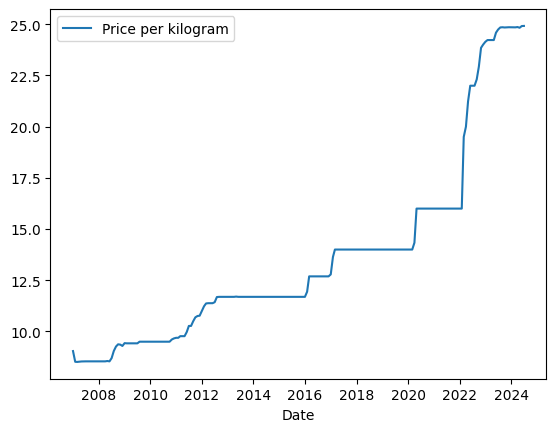

In [64]:
sns.lineplot(data= df)

In [58]:
# df['Average_Per_Month'] = df.groupby(['Year', 'Month'])['Price per kilogram'].transform('mean')

In [59]:
# for year in df['Year'].unique():
#     for month in (df[df['Year'] == year]['Month'].unique()):
#         df_t = df[(df['Year'] == year) & (df['Month'] == month)]
#         Average_Per_Month = df_t['Price per kilogram'].sum() / df_p.shape[0]
#         df[(df['Year'] == year) & (df['Month'] == month)]['Average_Per_Month'] = Average_Per_Month
# 
# df = df.drop(columns = "Price per kilogram")
# df

## **1- Avance**

Define el problema, descripción de la serie de tiempo. ¿Cuál es el motivo o la necesidad de pronosticar? ¿Cuánto tiempo en el futuro es necesario pronosticar y por qué? ¿Estos datos, en el mundo real que representan?  
El precio de la tortilla en mexico al ser un producto de alto consumo en el pais, afecta a muchos segmentos del mismo, se intentaria predecir los siguientes 6 meses para asi poder ver como es que este precio puede variar de mejor manera, en el mundo real esto nos ayudaria nos podria ayudar a ver si es conveniente por ejemplo abrir una tortilleria  

Recaba la información. ¿Cómo se recopilan? ¿Cada cuanto se recopilan? ¿Desde cuándo existen o desde cuándo vas a utilizar? ¿De dónde se obtienen?   
Se recuperan de manera constante desde una base de datos del gorbieno de mexico sin embargo no s recolecta todos los dias por lo que esta salteado por dias

Comienza tu análisis exploratorio. ¿Cuáles son las características de la serie de tiempo? ¿tiene patrones? ¿valores atípicos? ¿Cuáles son las medidas estadísticas de tendencia central y de dispersión?  
